# Question 8.2
Using crime data from http://www.statsci.org/data/general/uscrime.txt  (file uscrime.txt, description at http://www.statsci.org/data/general/uscrime.html ), use regression (a useful R function is lm or glm) to predict the observed crime rate in a city with the following data:

M = 14.0
So = 0
Ed = 10.0
Po1 = 12.0
Po2 = 15.5
LF = 0.640
M.F = 94.0
Pop = 150
NW = 1.1
U1 = 0.120
U2 = 3.6
Wealth = 3200
Ineq = 20.1
Prob = 0.04
Time = 39.0

Show your model (factors used and their coefficients), the software output, and the quality of fit. 


http://www.statsci.org/data/general/uscrime.html

	Variable	 	Description
M		percentage of males aged 14–24 in total state population
So		indicator variable for a southern state
Ed		mean years of schooling of the population aged 25 years or over
Po1		per capita expenditure on police protection in 1960
Po2		per capita expenditure on police protection in 1959
LF		labour force participation rate of civilian urban males in the age-group 14-24
M.F		number of males per 100 females
Pop		state population in 1960 in hundred thousands
NW		percentage of nonwhites in the population
U1		unemployment rate of urban males 14–24
U2		unemployment rate of urban males 35–39
Wealth		wealth: median value of transferable assets or family income
Ineq		income inequality: percentage of families earning below half the median income
Prob		probability of imprisonment: ratio of number of commitments to number of offenses
Time		average time in months served by offenders in state prisons before their first release
Crime		crime rate: number of offenses per 100,000 population in 1960

# Notes/Analysis:
##Only one of Po1 and Po2, and only one of U1 and U2, remain in the final regression, because of high collinearity.
##Data gives association not causal relationships. For example, does crime really increase with police expenditure?
##Crime is negatively associated with probability of imprisonment.
##Crime is slightly better modelled on a log scale.

In [19]:
##########LIBRARY##########
library("ggplot2")
#install.packages("devtools")
#install.packages("corrplot")
library("devtools")
library("corrplot") # to use Correlation plot
library(tidyr) # to get "gather" function
library(plyr) #to use arrange function


In [7]:
##########INGEST FILE##########

#crime<- read.table("C:\\Preethi\\R\\USCrimes.txt",header=TRUE,stringsAsFactors = FALSE,sep="\t")
#head(data,10)
#colClasses = c("numeric", "numeric", "numeric")
#colClasses
crime = read.table("C:\\Preethi\\R\\USCrimes.txt",header=TRUE,stringsAsFactors = FALSE,sep="\t") %>% as_tibble()
head(crime,2)


M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635


# # study relationship of predictors with Crime output

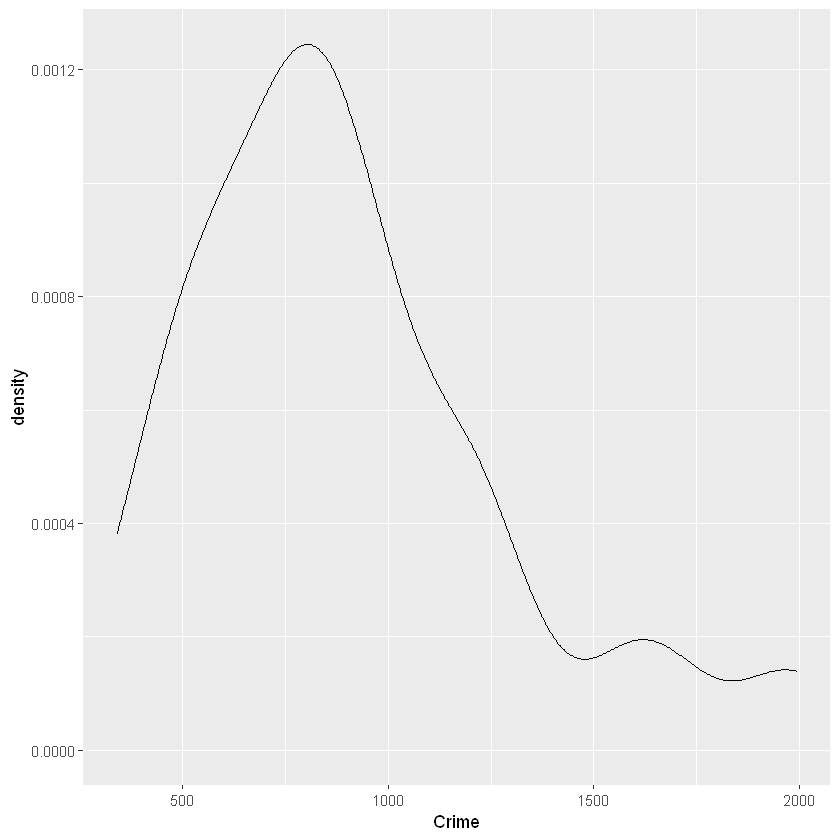

In [12]:
# show density of data spread
ggplot(data = crime, aes(x = Crime)) +geom_density() 
#negative skew

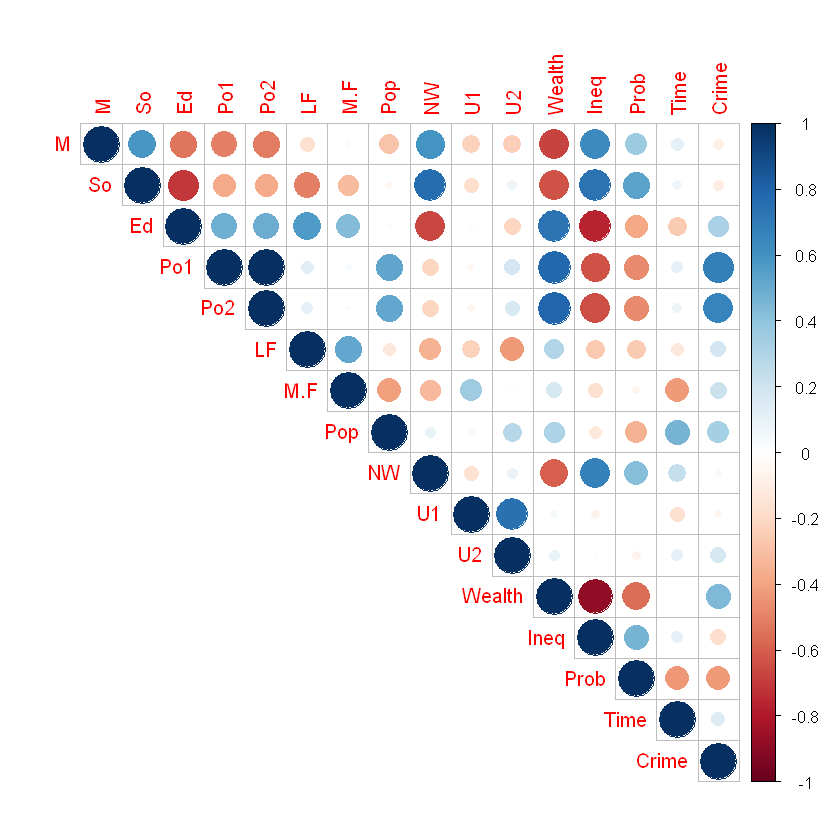

In [9]:
# to show correlation f predictors
corrplot(cor(crime),type = 'upper') 
#1. observation Po1 and Po2;U1  only one of U1 and U2 are highly corelated
#Only one of P01 or P02 and U1 and U2 will be used for Regression (PO:per Capita expenditure;U:Unemployement rate)
#2.Crime is negatively associated with probability of imprisonment(prob)-in red.
#3.Wealth and Inequ has high negative corelation.

In [40]:
cor(crime$Crime, crime[,1:15]) %>%
        as_tibble() %>%
        gather(predictor, correlation) %>% #transform crosstab to rows
        arrange(desc(correlation)) #sort by desc
#highest Correlation to "y=Crime" is most likely predictor(red circle in correlation plot)

predictor,correlation
<chr>,<dbl>
Po1,0.68760446
Po2,0.66671414
Wealth,0.44131995
Pop,0.33747406
Ed,0.32283487
M.F,0.21391426
LF,0.18886635
U2,0.17732065
Time,0.14986606


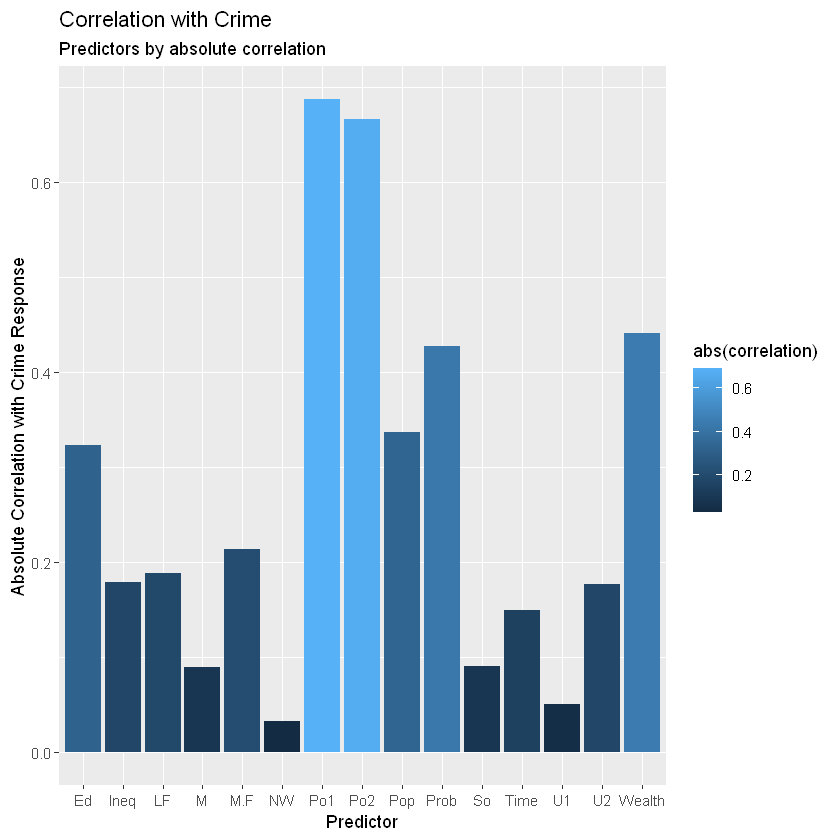

In [30]:
# study relationship of predictors with Crime output
cor(crime$Crime, crime[,1:15]) %>%
        as_tibble() %>%
        gather(predictor, correlation) %>%
        arrange(desc(correlation)) %>% 
        ggplot(data = ., aes(x = predictor, y = abs(correlation), fill = abs(correlation))) +
        geom_col() + 
        labs(title = 'Correlation with Crime',
             subtitle = 'Predictors by absolute correlation') + 
        xlab('Predictor') + 
        ylab('Absolute Correlation with Crime Response')

In [41]:
#create data frame based on predictors that matters
crime_df = crime %>% 
        dplyr::select(Crime, Po1,Wealth,Prob,Ed,Pop,Ineq,M.F)

#Result(y)
#Crime		crime rate: number of offenses per 100,000 population in 1960

#PREDICTORS that impacts results

#Po1		per capita expenditure on police protection in 1960
#Wealth		wealth: median value of transferable assets or family income
#Prob		probability of imprisonment: ratio of number of commitments to number of offenses
#Ed		mean years of schooling of the population aged 25 years or over
#Pop		state population in 1960 in hundred thousands
#Ineq		income inequality: percentage of families earning below half the median income
#M.F		number of males per 100 females

In [42]:
# develop predictor data and response labels
crime_x = data.frame(crime_df) %>% dplyr::select(., -Crime) #exclude "Y-output"
crime_y = data.frame(crime_df) %>% dplyr::select(., Crime) #include only Y-output"

In [43]:
#Just curios on Box Cox transformation
transform_df = caret::preProcess(crime_x,  method = c('center', 'scale', 'nzv', 'BoxCox'))
transform_df


Created from 47 samples and 7 variables

Pre-processing:
  - Box-Cox transformation (7)
  - centered (7)
  - ignored (0)
  - scaled (7)

Lambda estimates for Box-Cox transformation:
-0.4, 1.8, 0.4, 2, 0.1, -0.3, -2

# Linear model

In [65]:
lm.crime_matters <- lm(Crime~., data=crime_df) #Out Crime related(~) to input);use only the impactful predictors

ERROR: Error in eval(expr, envir, enclos): object 'my_crime_regression' not found


In [60]:
summary(lm.crime_matters)


Call:
lm(formula = Crime ~ ., data = crime_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-487.51 -128.62   13.12  137.85  436.04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.506e+03  1.370e+03  -3.290  0.00213 ** 
Po1          1.185e+02  2.031e+01   5.834 8.81e-07 ***
Wealth       8.053e-02  9.945e-02   0.810  0.42298    
Prob        -3.884e+03  1.757e+03  -2.211  0.03300 *  
Ed           1.019e+02  5.278e+01   1.930  0.06086 .  
Pop         -1.196e+00  1.247e+00  -0.959  0.34335    
Ineq         8.811e+01  2.006e+01   4.392 8.33e-05 ***
M.F          1.447e+01  1.437e+01   1.007  0.32020    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 218.9 on 39 degrees of freedom
Multiple R-squared:  0.7285,	Adjusted R-squared:  0.6798 
F-statistic: 14.95 on 7 and 39 DF,  p-value: 2.697e-09


In [63]:
#Display Coefficiensts of predictors as table
coef(lm.crime_matters) %>% as.data.frame()

,.
,<dbl>
(Intercept),-4.506418e+03
Po1,1.184710e+02
Wealth,8.053154e-02
Prob,-3.883680e+03
Ed,1.018860e+02
Pop,-1.195830e+00
Ineq,8.810809e+01
M.F,1.447042e+01


# Prediction

In [64]:
new_observe = data.frame(
        M = 14.0,
        So = 0,
        Ed = 10.0,
        Po1 = 12.0,
        Po2 = 15.5,
        LF = 0.640,
        M.F = 94.0 ,
        Pop = 150,
        NW = 1.1,
        U1 = 0.120,
        U2 = 3.6 ,
        Wealth = 3200, 
        Ineq = 20.1 ,
        Prob = 0.04 ,
        Time = 39.0
)

In [71]:
# crime prediction for new point of observation based on model
crime_pred = predict(lm.crime_matters, new_observe) %>% 
        as_tibble()
crime_pred

value
<dbl>
988.2651


In [69]:
print(paste('Crime Predicted for the new point of observation: ', crime_pred$value))

[1] "Crime Predicted for the new point of observation:  988.265064911191"


#Notes
https://www.learnbymarketing.com/tutorials/linear-regression-in-r/